<h1 align=center><font size = 5>SPE Europe Energy GeoHackathon</font></h1>

Society of Petroleum Engieers|  ERCE Equipoise | Geothermal Challenge  
:-------------------------:|:-------------------------:|:-------------------------:
<a href="https://www.spehackathon-eu.com"> <img src = "https://upload.wikimedia.org/wikipedia/en/thumb/4/42/Society_of_Petroleum_Engineers_Logo.svg/1200px-Society_of_Petroleum_Engineers_Logo.svg.png" width = 200 /> | <a href="https://www.erce.energy/"> <img src = "https://energycouncil.com/wp-content/uploads/ERCE.png" width = 200/> | <img src = "https://solutions.vallourec.com/-/media/Solutions-img/Low-Carbon-Energy/Medias/Geothermal-energy/Header-Corner_Geothermal.ashx" width = 200/>
    


<h1 align=center><font size = 4> Team ERCE - Munish Kumar, Kanna Swaminathan & Ivan Maulana </font></h1>
<h1 align=center><font size = 3> 2021 </font></h1>

In [1]:
# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import seaborn as sns
import math

import time
import re
import requests
import pickle
import os
import glob
import scipy
import sys
import warnings

import plotly.express as px
import plotly.graph_objects as go 

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

warnings.filterwarnings('ignore')
sns.set()

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


###### Declare some global variables

In [2]:
# Change dir_name = Path Name as needed 
dir_name = r'C:\Users\mkumar\Documents\GitHub\@Working\SPE_GeoHackathon\4_Submission_14122021\Sect3.2_Static_Properties\Input'
filename_suffix = 'txt'
filename_suffix2 = 'csv'

Function to read multiple text files and process for static properties

In [3]:
def interp_well(dir_name, base_filename, filename_suffix):
    skiprows = 3
    base_filename = base_filename
    csvs_sht = os.path.join(dir_name, base_filename + '.' + filename_suffix)

    data = pd.read_csv(csvs_sht, delimiter = "\t", skiprows = skiprows, header=None)
    data.columns = ["Depth (m)", "Transit Time (micron/sec)"]
        
    #Check the data
    print("------------------Checking the Data---------------")   
    print(data.head())
    print("------------------Type of Data---------------")   
    print(data.info())
    print("------------------Checking for missing points visually---------------")   
    
    fig, ax = plt.subplots(figsize=(25,8))
    sns.heatmap(data.isnull(), ax=ax, cmap="magma")
    plt.grid()
    plt.show()

    # 3 functions. 
    # 1. Function "calc_poro" evaluates porosity
    # 2. Function "crossplot2" create visual of evaluation
    # 3. Function "filter_for_stats" outputs the statistics for the relevant sections
    log_df = calc_poro(data)
    crossplot2(log_df)
  
    print("------------------Export Stats of Relevance---------------")
    max_pu = 0.25
    log_df_stats = filter_for_stats(log_df,max_pu)
    
    print("------------------Writing out the file---------------") 
    csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix2)
    log_df_stats.to_csv(csvs_sht, index = True, header=True)
    print ("Final File Extract Produced") 
    
    return

In [4]:
# Porosity based on Wyllie
def calc_poro(data):
    
    # There is likely an error in the units. Its probably microsecs/ meter
    # not micron/sec because if it is the latter then DT would be insanely large and not physical.
    DT = data["Transit Time (micron/sec)"][1:].apply(pd.to_numeric).reset_index(drop = True) #This assumes data is in micro sec / ft 
    DT = DT/3.2808 # This assumes data is in micro sec/m, data is now converted to micro sec/ft
    
    # Assume sandstone. DT_MASD is delta time of quartz and DT_F is delta fime of fluid
    # B is a compaction factor
    DT_F = 191                # units micro sec/ft
    DT_MASD = 56              # units micro sec/ft
    Cp = (240/3.2808)/100     # Cp = DT_shale/100 is compaction factor, assume 240 us/ft is shale transit time
    Hy = 1                    # Hy is hydrocarbon correction
         
    # PHIT based on Wyllie
    PHIA = ((DT - DT_MASD)/(DT_F - DT_MASD))*(Hy/Cp) 
    PHIA = np.where(PHIA > 0, PHIA, 0.001) # Corrects in cases where PHIA is negative
    
    data.drop(index=data.index[0], axis=0, inplace=True)
    
    data['Porosity (V/V)'] = PHIA
    data = data.apply(pd.to_numeric)
    return data   

In [5]:
def crossplot2(log_df):
    print("------------------Data set for visualisation---------------")
    print(log_df.head())
    print("------------------Descriptive Statistics for Data set---------------")    
    print(log_df.describe())
    
    fig, ax = plt.subplots(figsize=(10,10))

    #Set up the plot axes
    ax1 = plt.subplot2grid((1,2), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,2), (0,1), rowspan=1, colspan = 1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    ax7 = ax1.twiny()
    ax7.xaxis.set_visible(False)
    ax8 = ax2.twiny()
    ax8.xaxis.set_visible(False)

    # Sonic track; assume that Transit Time units are wrong
    ax1.plot('Transit Time (micron/sec)', 'Depth (m)', data = log_df, color = "purple")
    ax1.set_xlabel("Sonic DT (usec/ m)")
    ax1.set_xlim(440, 40)
    ax1.xaxis.label.set_color("purple")
    ax1.tick_params(axis='x', colors="purple")
    ax1.spines["top"].set_edgecolor("purple")
    ax1.set_xticks([440, 340, 240, 140, 40])

    # Porosity track
    ax2.plot("Porosity (V/V)", "Depth (m)", data = log_df, color = "blue")
    ax2.set_xlabel('Porosity (V/V)')
    ax2.xaxis.label.set_color("blue")
    ax2.set_xlim(0.5, 0)
    ax2.tick_params(axis='x', colors="blue")
    ax2.spines["top"].set_position(("axes", 1.08))
    ax2.spines["top"].set_visible(True)
    ax2.spines["top"].set_edgecolor("blue")
    ax2.set_xticks([0.5, 0.4, 0.3, 0.2, 0.1, 0])
    
    # Common functions for setting up the plot can be extracted into
    # a for loop. This saves repeating code.
    for ax in [ax1, ax2]:
        ax.set_ylim(np.min(log_df['Depth (m)']), np.max(log_df['Depth (m)']))
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))  
    
    plt.tight_layout()
    plt.show()
    return

In [6]:
def filter_for_stats(log_df, max_pu):     
    df_sst = log_df[log_df["Porosity (V/V)"] <= max_pu]
    print(df_sst.describe())
    return df_sst.describe()

#### The following code evaluates the static properties. The input file does not provide any stratigraphic tops or gamma ray log. Only a sonic log was provided

#### Therefore, the assumption we are making are
1. That this entire log is only across the reservoir section
2. That this is a sandstone reservoir (with shale breaks in between the sands)
3. That the well is vertical
4. That high porosity values are for shales; sandstone porosity is naturally limited to max case of 0.45 p.u.

------------------Checking the Data---------------
   Depth (m)   Transit Time (micron/sec)
0   depth(m)   transit time (micron/sec)
1  2308.8300                  237.915924
2  2308.9439                  237.084505
3  2309.0579                  235.747799
4  2309.1718                  238.900018
------------------Type of Data---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Depth (m)                  501 non-null    object
 1   Transit Time (micron/sec)  501 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB
None
------------------Checking for missing points visually---------------


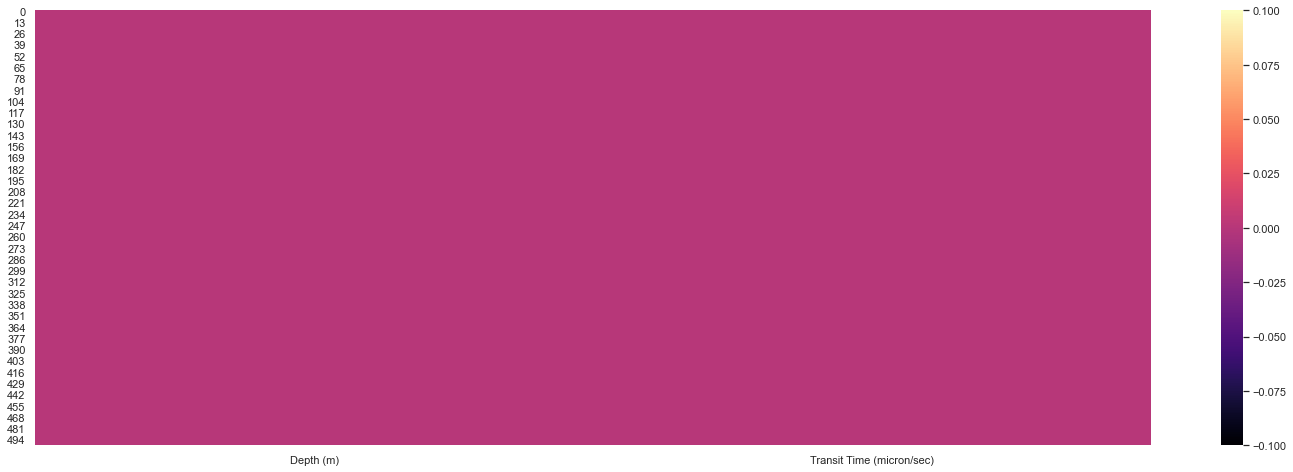

------------------Data set for visualisation---------------
   Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
1  2308.8300                 237.915924        0.167257
2  2308.9439                 237.084505        0.164690
3  2309.0579                 235.747799        0.160565
4  2309.1718                 238.900018        0.170294
5  2309.2858                 234.965882        0.158151
------------------Descriptive Statistics for Data set---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count   500.000000                 500.000000      500.000000
mean   2337.260000                 238.920474        0.170384
std      16.463401                  25.094963        0.077393
min    2308.830000                 179.726306        0.001000
25%    2323.045000                 213.544965        0.092038
50%    2337.260000                 244.401803        0.187275
75%    2351.475000                 254.710681        0.219092
max    2365.690000                 280.

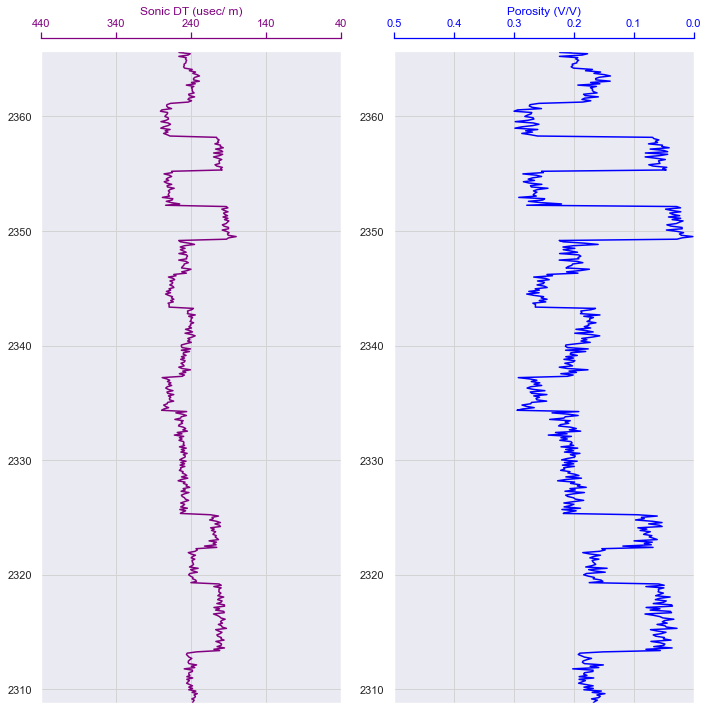

------------------Export Stats of Relevance---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count   410.000000                 410.000000      410.000000
mean   2334.648370                 231.880539        0.148661
std      16.530415                  22.116765        0.068188
min    2308.830000                 179.726306        0.001000
25%    2320.481175                 206.642674        0.070734
50%    2332.132350                 240.251004        0.174464
75%    2348.341425                 248.752507        0.200703
max    2365.690000                 264.391755        0.248972
------------------Writing out the file---------------
Final File Extract Produced


In [7]:
df1 = interp_well(dir_name, 'E01_welllogs', filename_suffix)

------------------Checking the Data---------------
   Depth (m)   Transit Time (micron/sec)
0   depth(m)   transit time (micron/sec)
1  2027.9900                  234.568691
2  2028.4132                  232.559050
3  2028.8364                  222.612878
4  2029.2596                  236.378002
------------------Type of Data---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Depth (m)                  501 non-null    object
 1   Transit Time (micron/sec)  501 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB
None
------------------Checking for missing points visually---------------


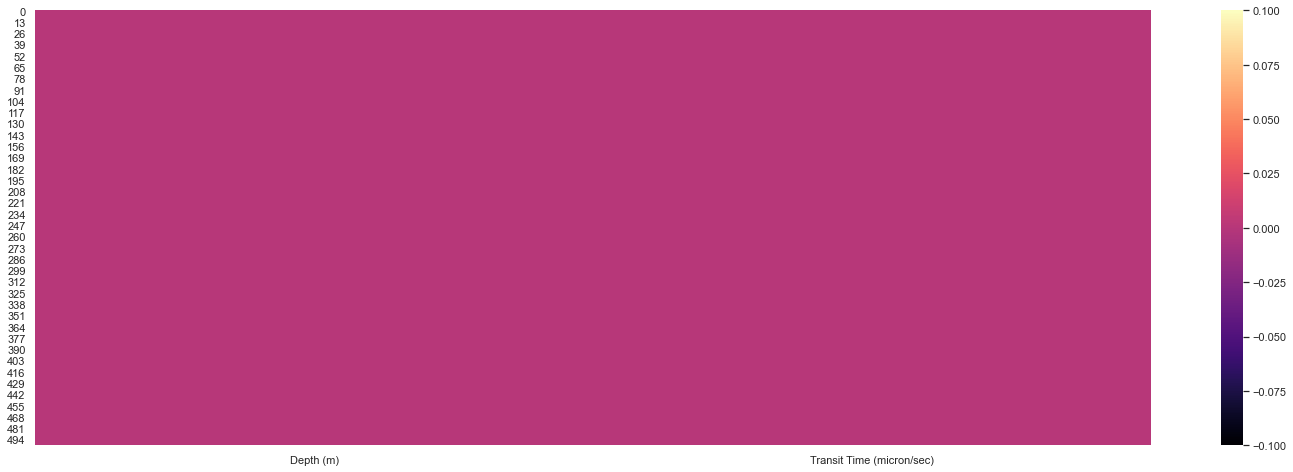

------------------Data set for visualisation---------------
   Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
1  2027.9900                 234.568691        0.156926
2  2028.4132                 232.559050        0.150723
3  2028.8364                 222.612878        0.120025
4  2029.2596                 236.378002        0.162510
5  2029.6828                 229.244282        0.140492
------------------Descriptive Statistics for Data set---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count   500.000000                 500.000000      500.000000
mean   2133.580000                 243.140640        0.183382
std      61.145638                  13.188465        0.040705
min    2027.990000                 205.503390        0.067218
25%    2080.785000                 237.053276        0.164594
50%    2133.580000                 243.931912        0.185824
75%    2186.375000                 250.428316        0.205875
max    2239.170000                 278.

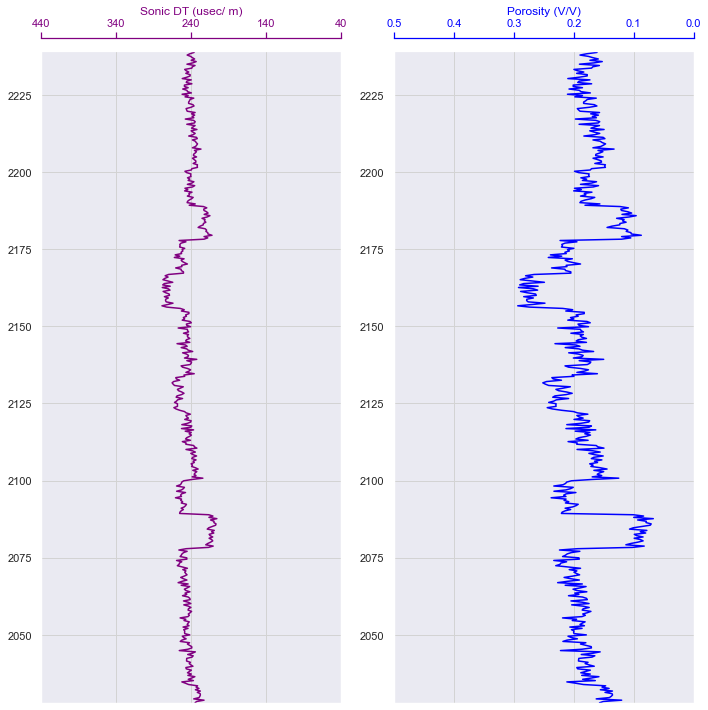

------------------Export Stats of Relevance---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count   475.000000                 475.000000      475.000000
mean   2132.170054                 241.580514        0.178567
std      62.400545                  11.560035        0.035679
min    2027.990000                 205.503390        0.067218
25%    2078.140000                 236.370744        0.162487
50%    2128.289900                 243.409540        0.184212
75%    2189.020000                 249.130825        0.201870
max    2239.170000                 264.375013        0.248920
------------------Writing out the file---------------
Final File Extract Produced


In [8]:
df2 = interp_well(dir_name, 'E03_welllogs', filename_suffix)

------------------Checking the Data---------------
   Depth (m)   Transit Time (micron/sec)
0   depth(m)   transit time (micron/sec)
1  1842.9300                  241.527030
2  1843.2070                  230.261838
3  1843.4840                  230.738602
4  1843.7610                  235.578155
------------------Type of Data---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Depth (m)                  501 non-null    object
 1   Transit Time (micron/sec)  501 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB
None
------------------Checking for missing points visually---------------


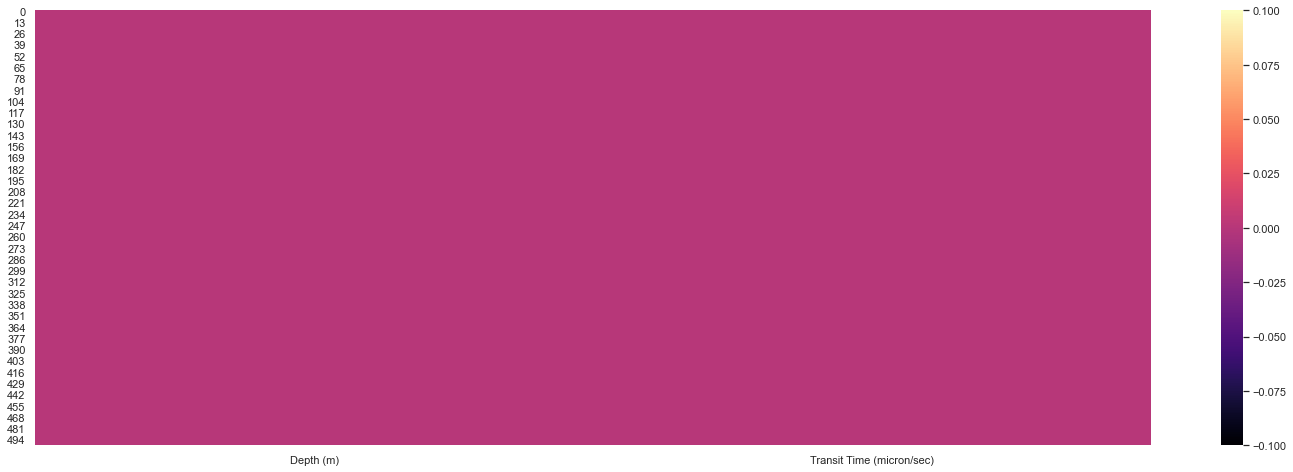

------------------Data set for visualisation---------------
   Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
1   1842.930                 241.527030        0.178402
2   1843.207                 230.261838        0.143633
3   1843.484                 230.738602        0.145104
4   1843.761                 235.578155        0.160041
5   1844.038                 239.473500        0.172064
------------------Descriptive Statistics for Data set---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count   500.000000                 500.000000      500.000000
mean   1912.040000                 231.364325        0.147114
std      40.020599                  22.507715        0.069298
min    1842.930000                 178.909434        0.001000
25%    1877.484975                 210.800743        0.083568
50%    1912.040000                 236.145272        0.161792
75%    1946.595025                 247.872491        0.197987
max    1981.150000                 273.

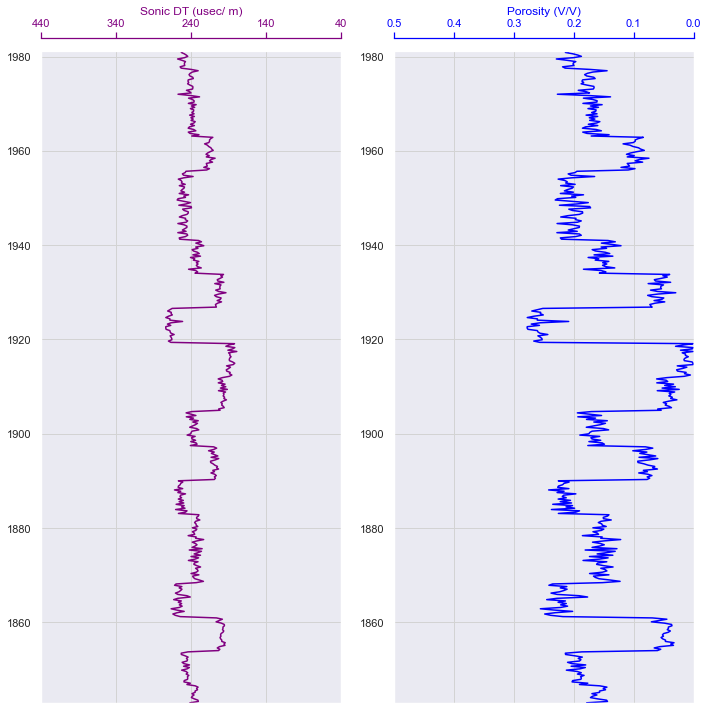

------------------Export Stats of Relevance---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count   474.000000                 474.000000      474.000000
mean   1911.564318                 229.327260        0.140831
std      40.959932                  21.308910        0.065586
min    1842.930000                 178.909434        0.001000
25%    1875.961550                 208.836118        0.077504
50%    1908.716100                 235.125463        0.158644
75%    1948.395450                 245.954353        0.192067
max    1981.150000                 264.238585        0.248499
------------------Writing out the file---------------
Final File Extract Produced


In [9]:
df3 = interp_well(dir_name, 'E05_welllogs', filename_suffix)

------------------Checking the Data---------------
   Depth (m)   Transit Time (micron/sec)
0   depth(m)   transit time (micron/sec)
1  2017.7900                  232.763285
2  2017.8581                  233.375255
3  2017.9262                  225.447232
4  2017.9943                  237.962389
------------------Type of Data---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Depth (m)                  501 non-null    object
 1   Transit Time (micron/sec)  501 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB
None
------------------Checking for missing points visually---------------


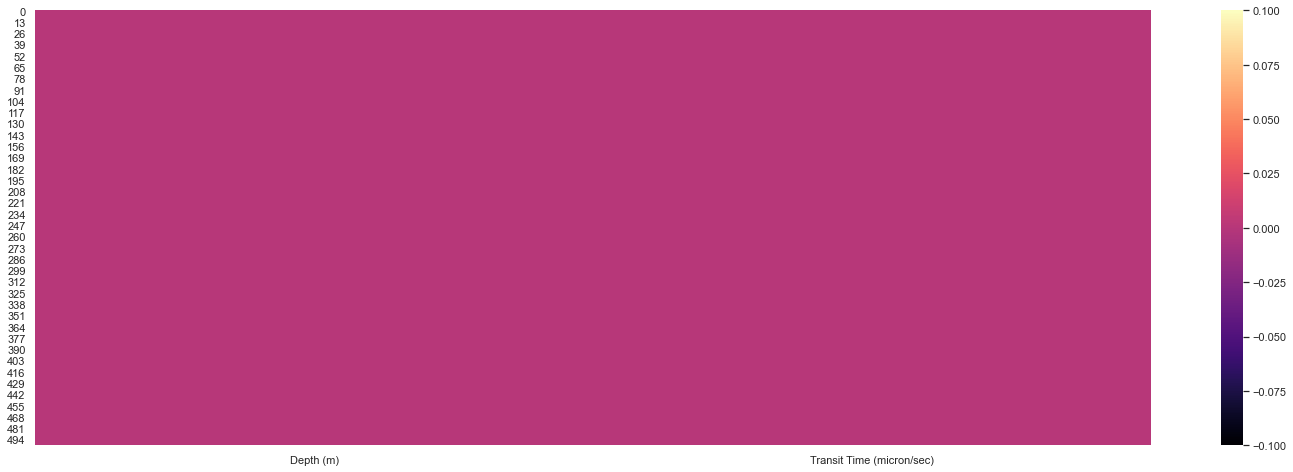

------------------Data set for visualisation---------------
   Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
1  2017.7900                 232.763285        0.151353
2  2017.8581                 233.375255        0.153242
3  2017.9262                 225.447232        0.128773
4  2017.9943                 237.962389        0.167400
5  2018.0625                 235.482800        0.159747
------------------Descriptive Statistics for Data set---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count   500.000000                 500.000000      500.000000
mean   2034.785000                 252.330882        0.211747
std       9.841559                  13.570179        0.041883
min    2017.790000                 215.666302        0.098585
25%    2026.287475                 242.146657        0.180314
50%    2034.785000                 254.386190        0.218091
75%    2043.282525                 263.219205        0.245353
max    2051.780000                 279.

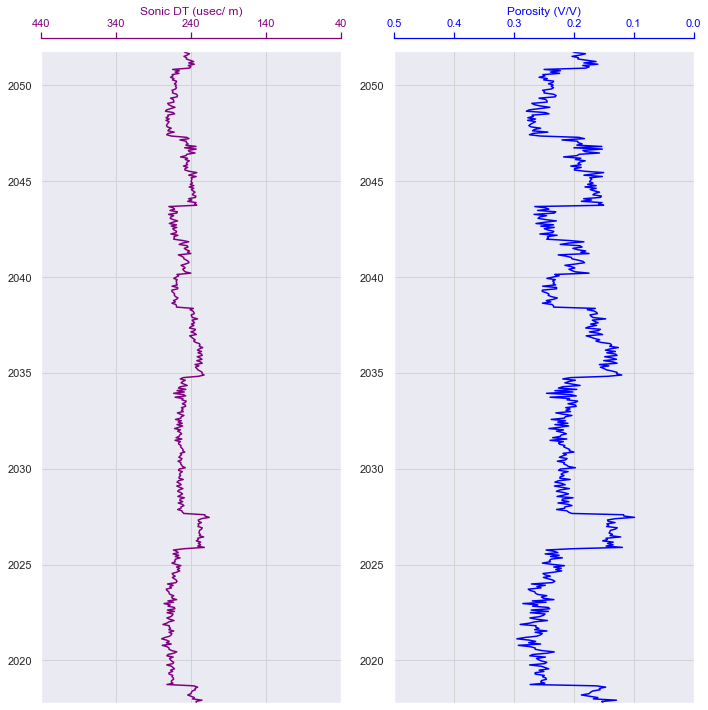

------------------Export Stats of Relevance---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count   402.000000                 402.000000      402.000000
mean   2035.581892                 248.202567        0.199005
std       8.934600                  11.813403        0.036461
min    2017.790000                 215.666302        0.098585
25%    2028.637525                 238.783421        0.169934
50%    2035.466150                 250.807704        0.207046
75%    2042.686450                 258.548662        0.230938
max    2051.780000                 264.650728        0.249771
------------------Writing out the file---------------
Final File Extract Produced


In [10]:
df4 = interp_well(dir_name, 'I02_welllogs', filename_suffix)

------------------Checking the Data---------------
   Depth (m)   Transit Time (micron/sec)
0   depth(m)   transit time (micron/sec)
1  1974.9600                  220.479739
2  1975.3006                  215.669687
3  1975.6412                  209.846644
4  1975.9818                  217.550213
------------------Type of Data---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Depth (m)                  501 non-null    object
 1   Transit Time (micron/sec)  501 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB
None
------------------Checking for missing points visually---------------


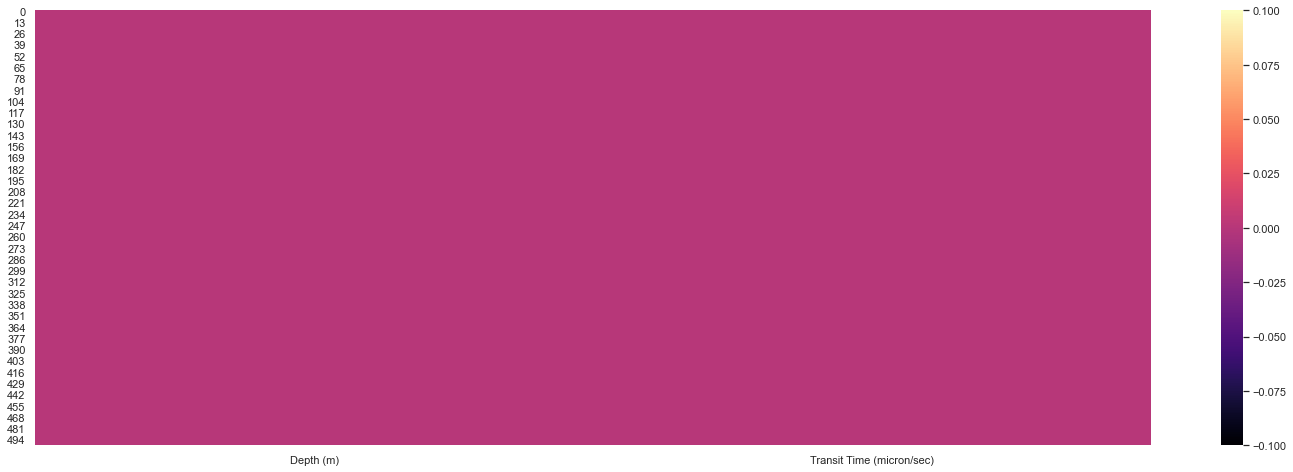

------------------Data set for visualisation---------------
   Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
1  1974.9600                 220.479739        0.113441
2  1975.3006                 215.669687        0.098595
3  1975.6412                 209.846644        0.080623
4  1975.9818                 217.550213        0.104399
5  1976.3224                 219.984475        0.111913
------------------Descriptive Statistics for Data set---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count   500.000000                 500.000000      500.000000
mean   2059.940000                 236.960773        0.164309
std      49.210688                  19.385963        0.059833
min    1974.960000                 192.052272        0.025702
25%    2017.450025                 225.388543        0.128592
50%    2059.940000                 234.924565        0.158024
75%    2102.429975                 248.501820        0.199929
max    2144.920000                 287.

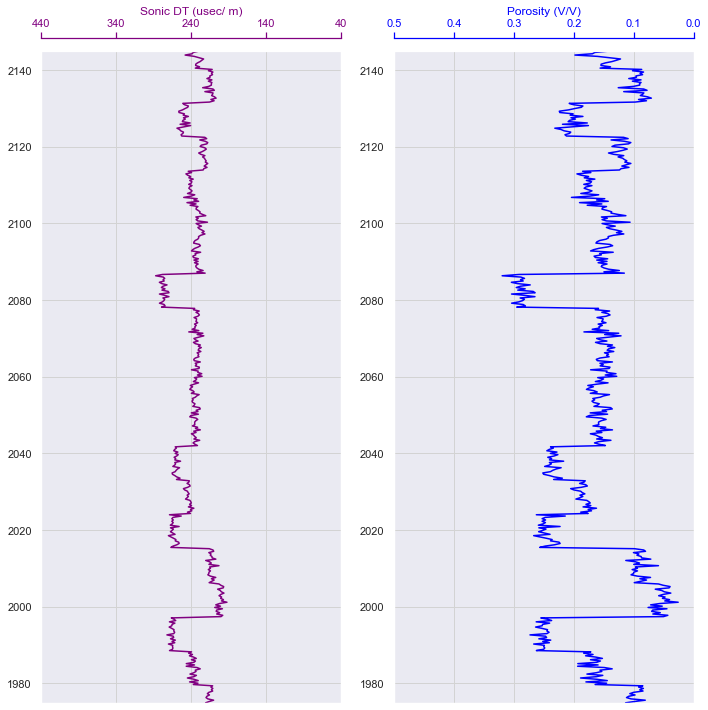

------------------Export Stats of Relevance---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count   448.000000                 448.000000      448.000000
mean   2061.668853                 232.899975        0.151775
std      49.975994                  16.018530        0.049440
min    1974.960000                 192.052272        0.025702
25%    2017.790650                 222.403146        0.119378
50%    2059.940000                 233.384796        0.153272
75%    2106.857850                 241.697096        0.178927
max    2144.920000                 264.395927        0.248985
------------------Writing out the file---------------
Final File Extract Produced


In [11]:
df5 = interp_well(dir_name, 'I03_welllogs', filename_suffix)

------------------Checking the Data---------------
   Depth (m)   Transit Time (micron/sec)
0   depth(m)   transit time (micron/sec)
1  2267.7400                  246.781006
2  2267.9080                  240.362193
3  2268.0760                  237.344548
4  2268.2439                  241.465081
------------------Type of Data---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Depth (m)                  501 non-null    object
 1   Transit Time (micron/sec)  501 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB
None
------------------Checking for missing points visually---------------


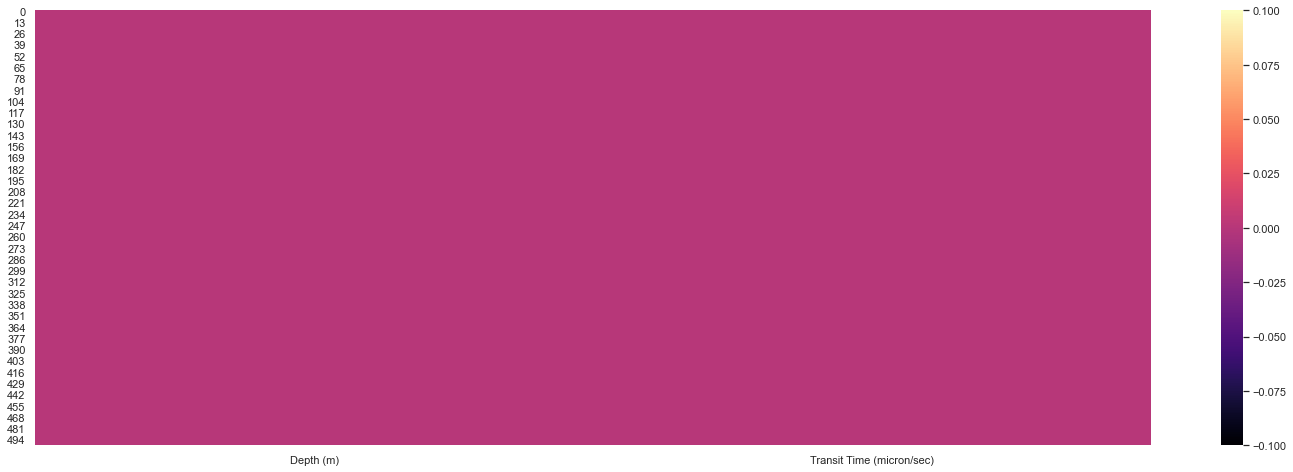

------------------Data set for visualisation---------------
   Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
1  2267.7400                 246.781006        0.194618
2  2267.9080                 240.362193        0.174807
3  2268.0760                 237.344548        0.165493
4  2268.2439                 241.465081        0.178211
5  2268.4119                 237.635330        0.166391
------------------Descriptive Statistics for Data set---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count   500.000000                 500.000000      500.000000
mean   2309.650000                 244.009199        0.188311
std      24.269473                  24.701907        0.069797
min    2267.740000                 161.839060        0.001000
25%    2288.695000                 231.176010        0.146454
50%    2309.650000                 245.377702        0.190287
75%    2330.605000                 261.864776        0.241173
max    2351.560000                 284.

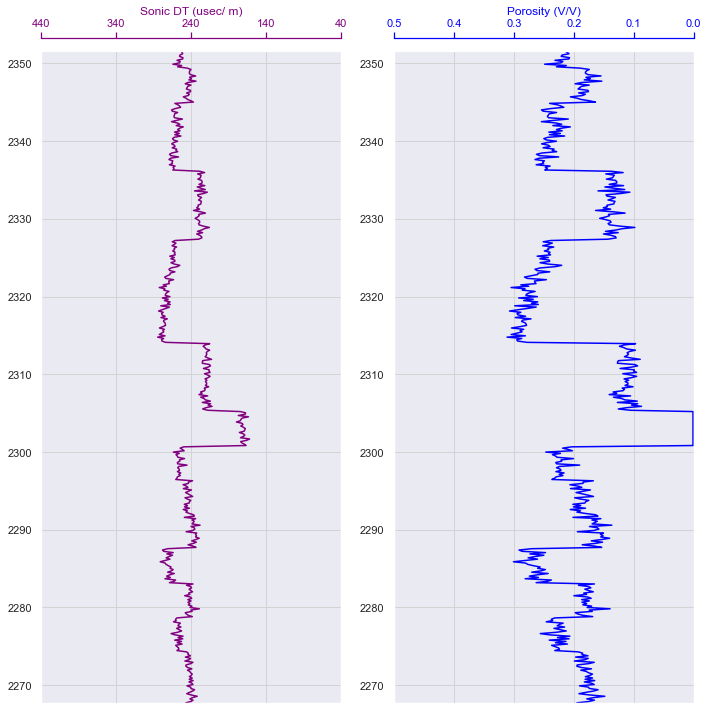

------------------Export Stats of Relevance---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count   404.000000                 404.000000      404.000000
mean   2308.574787                 237.254945        0.167999
std      25.508682                  22.610765        0.061805
min    2267.740000                 161.839060        0.001000
25%    2288.359025                 227.322665        0.134561
50%    2305.282600                 240.820983        0.176223
75%    2332.452700                 254.590476        0.218721
max    2351.560000                 264.682875        0.249871
------------------Writing out the file---------------
Final File Extract Produced


In [12]:
df6 = interp_well(dir_name, 'P01_welllogs', filename_suffix)

### Conclusion

In [ ]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))